In [1]:
# This notebook demonstrates the equality of the old parquet output and the proposed xarray output

In [2]:
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
dirname = '20240723_133455'

In [4]:
# Use xarray

In [5]:
simout = xr.open_dataset(f"model_output/sample_2pop/{dirname}/seir/000000001.{dirname}.seir.parquet.nc")

In [6]:
simout

<xarray.Dataset> Size: 17kB
Dimensions:          (date: 121, infection_stage: 4, subpop: 2)
Coordinates:
  * date             (date) datetime64[ns] 968B 2020-02-01 ... 2020-05-31
  * infection_stage  (infection_stage) object 32B 'S' 'E' 'I' 'R'
  * subpop           (subpop) object 16B 'large_province' 'small_province'
Data variables:
    prevalence       (date, infection_stage, subpop) float64 8kB ...
    incidence        (date, infection_stage, subpop) float64 8kB ...
Attributes:
    description:  Dynamical simulation results
    run_id:       20240723_133455

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


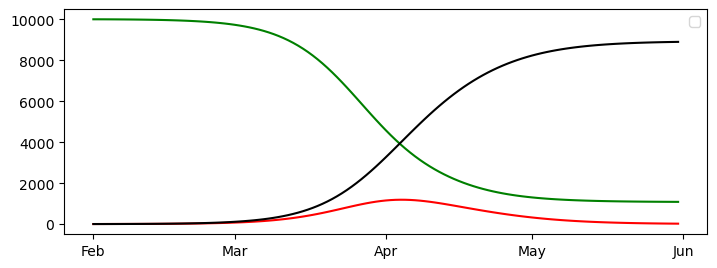

In [7]:
fig,ax = plt.subplots(figsize=(8.3,11.7/4))
ax.plot(simout['date'], simout.sel({'infection_stage': 'S'}).sum(dim='subpop')['prevalence'], color='green')
ax.plot(simout['date'], simout.sel({'infection_stage': 'I'}).sum(dim='subpop')['prevalence'], color='red')
ax.plot(simout['date'], simout.sel({'infection_stage': 'R'}).sum(dim='subpop')['prevalence'], color='black')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()
plt.close()

In [33]:
# Use parquet files

In [8]:
simout = pd.read_parquet(f"model_output/sample_2pop/{dirname}/seir/000000001.{dirname}.seir.parquet")

In [9]:
simout

,mc_value_type,mc_infection_stage,mc_name,large_province,small_province,date
0,incidence,S,S,0.000000,0.000000,2020-02-01
1,incidence,E,E,0.271162,0.000307,2020-02-01
2,incidence,I,I,1.127310,0.000024,2020-02-01
3,incidence,R,R,0.109133,0.000001,2020-02-01
4,incidence,S,S,0.000000,0.000000,2020-02-02
...,...,...,...,...,...,...
963,prevalence,R,R,8012.316100,876.539201,2020-05-30
964,prevalence,S,S,971.013228,111.283609,2020-05-31
965,prevalence,E,E,4.006324,2.945311,2020-05-31
966,prevalence,I,I,10.459541,7.625265,2020-05-31


In [10]:
# load the demography & extract index for spatial patches
demography = pd.read_csv(os.path.join(os.getcwd(), 'model_input/geodata_sample_2pop.csv'))
spatial_patches = demography['subpop'].unique()

# construct an empty pd.DataFrame with desired index (date, space, state)
dates = simout['date'].unique()
value_types = simout['mc_value_type'].unique()
disease_states = simout['mc_infection_stage'].unique()
idx = pd.MultiIndex.from_product([dates, spatial_patches, disease_states],
                           names=['date', 'spatial_patch', 'disease_state'])

# values as columns
value_types = simout['mc_value_type'].unique()

# construct the 'desired' dataframe
new_simout = pd.DataFrame(index=idx, columns=value_types)

# fill in the data
for sp in spatial_patches:
    for ds in disease_states:
        for vt in value_types:
            # slice data 
            tmp = simout[((simout['mc_value_type'] == vt) & (simout['mc_infection_stage'] == ds))][str(sp)]
            # fill in data
            new_simout.loc[(slice(None), sp, ds), vt] = tmp.values

In [11]:
new_simout

incidence   prevalence
date       spatial_patch  disease_state                       
2020-02-01 large_province S                   0.0       8995.0
                          E              0.271162          5.0
                          I               1.12731          0.0
                          R              0.109133          0.0
           small_province S                   0.0       1000.0
...                                           ...          ...
2020-05-31 large_province R              1.986548  8014.520907
           small_province S                   0.0   111.283609
                          E              0.398921     2.945311
                          I              0.698243     7.625265
                          R              1.448748   878.145815

[968 rows x 2 columns]

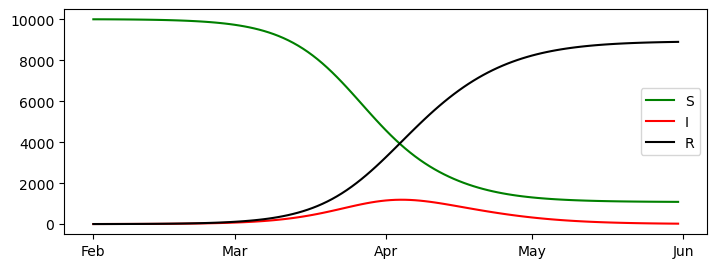

In [12]:
fig,ax=plt.subplots(figsize=(8.3, 11.7/4))

# aggregate over spatial patches
agg = new_simout['prevalence'].groupby(by=['date', 'disease_state']).sum()

ax.plot(dates, agg.loc[(slice(None), 'S')], color='green', label='S')
ax.plot(dates, agg.loc[(slice(None), 'I')], color='red', label='I')
ax.plot(dates, agg.loc[(slice(None), 'R')], color='black', label='R')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()
plt.close()